# GKGZ Sample Notebook

This notebook produces plots describing the input data sample.

In [1]:
# imports
import os
import sys
import copy
import glob
import time
import warnings
import functools
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.anchored_artists import (
    AnchoredSizeBar as scalebar
)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter
from scipy.ndimage import gaussian_filter
import astropy.units as u
from astropy.io import fits
from astropy.table import Table, join
from astropy.cosmology import FlatLambdaCDM
from astropy.coordinates import SkyCoord
import multiprocessing

# startup
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor':"w"}
def timecheck(start = None, timefmt = '%Y-%m-%d %H:%M:%S %Z'):
    now = time.time()
    out = time.strftime(timefmt, time.localtime(now))
    if start:
        diff = time.strftime('%H:%M:%S', time.gmtime(now-start))
        out += f' (elapsed: {diff})'
    return [now, out]
nbt0, nbt0str = timecheck()
print(f'Notebook start time:\n   {nbt0str}')
#--------------------------------68-------------------------------->

# one-liners
def seq(a, b, by): return np.arange(a, b + by/2, by)
def npmad(x): return 1.4826*np.nanmedian(np.abs(x-np.nanmedian(x)))
def ddir(x): return [y for y in dir(x) if not y.startswith('__')]
def minmax(x): return [np.nanmin(x), np.nanmax(x)]
def extendrange(x,f=0.05):u,v=minmax(x);d=(v-u)*(1+f);return v-d,u+d
def findin(x, y): return [l for l in list(x) if y in str(l)]
def z2dist(z): return FlatLambdaCDM(70, 0.3).luminosity_distance(z)
def mag2Mag(m, z): return m+5-5*np.log10(z2dist(z).to(u.pc).value)
def stripnan(x): return np.asarray(x)[~np.isnan(x)]
def qindex(a, q): return abs(a - np.percentile(a, q*100)).argmin()

Notebook start time:
   2021-02-15 22:17:05 CST


In [2]:
# suppress some ipython deprecation warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
outdir = os.path.abspath('.')
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [4]:
# plotting conversion functions
def fixRA(ra):
    return -((np.array(ra) - 180) * (np.pi/180))
def fixDEC(dec):
    return np.array(dec) * np.pi/180
# survey coordinates
kidsN = [[156, -5],
         [156, 4],
         [238, 4],
         [238, -3],
         [225, -3],
         [225, -5],
         [156, -5]]
kidsNW2 = [[127.5, -2],
           [127.5, 3],
           [142.5, 3],
           [142.5, -2],
           [127.5, -2]]
kidsND2 = [[149.5, 1],
           [149.5, 3],
           [150.5, 3],
           [150.5, 1],
           [149.5, 1]]
kidsS = [[360, -36],
         [360, -26],
         [330, -26],
         [330, -36],
         [360, -36],
         [180, -90],
         [0, -26],
         [52.5, -26],
         [52.5, -36],
         [0, -36],
         [0, -26],
         [180, -90],
         [360, -36]]
gama02 = [[30.2, -10.25],
          [30.2, -3.72],
          [38.8, -3.72],
          [38.8, -10.25],
          [30.2, -10.25]]
gama09 = [[129, -2],
          [129, 3],
          [141, 3],
          [141, -2],
          [129, -2]]
gama12 = [[174, -3],
          [174, 2],
          [186, 2],
          [186, -3],
          [174, -3]]
gama15 = [[211.5, -2],
          [211.5, 3],
          [223.5, 3],
          [223.5, -2],
          [211.5, -2]]
gama23 = [[339, -35],
          [339, -30],
          [351, -30],
          [351, -35],
          [339, -35]]
raKidsN, decKidsN = zip(*kidsN)
raKidsNW2, decKidsNW2 = zip(*kidsNW2)
raKidsND2, decKidsND2 = zip(*kidsND2)
raKidsS, decKidsS = zip(*kidsS)
raGama02, decGama02 = zip(*gama02)
raGama09, decGama09 = zip(*gama09)
raGama12, decGama12 = zip(*gama12)
raGama15, decGama15 = zip(*gama15)
raGama23, decGama23 = zip(*gama23)
# galactic plane coordinates
galactic = SkyCoord(np.linspace(0, 360, 100),
                    np.zeros(100),
                    unit='deg',
                    frame='galactic')
raGalactic,decGalactic = galactic.icrs.ra.deg,galactic.icrs.dec.deg
ooGalactic = np.argsort(raGalactic)
raGalactic = raGalactic[ooGalactic]
decGalactic = decGalactic[ooGalactic]
# ecliptic plane coordinates
ecliptic = SkyCoord(np.linspace(0, 360, 100),
                    np.zeros(100),
                    unit='deg',
                    frame='geocentrictrueecliptic')
raEcliptic,decEcliptic = ecliptic.icrs.ra.deg,ecliptic.icrs.dec.deg
ooEcliptic = np.argsort(raEcliptic)
raEcliptic = raEcliptic[ooEcliptic]
decEcliptic = decEcliptic[ooEcliptic]

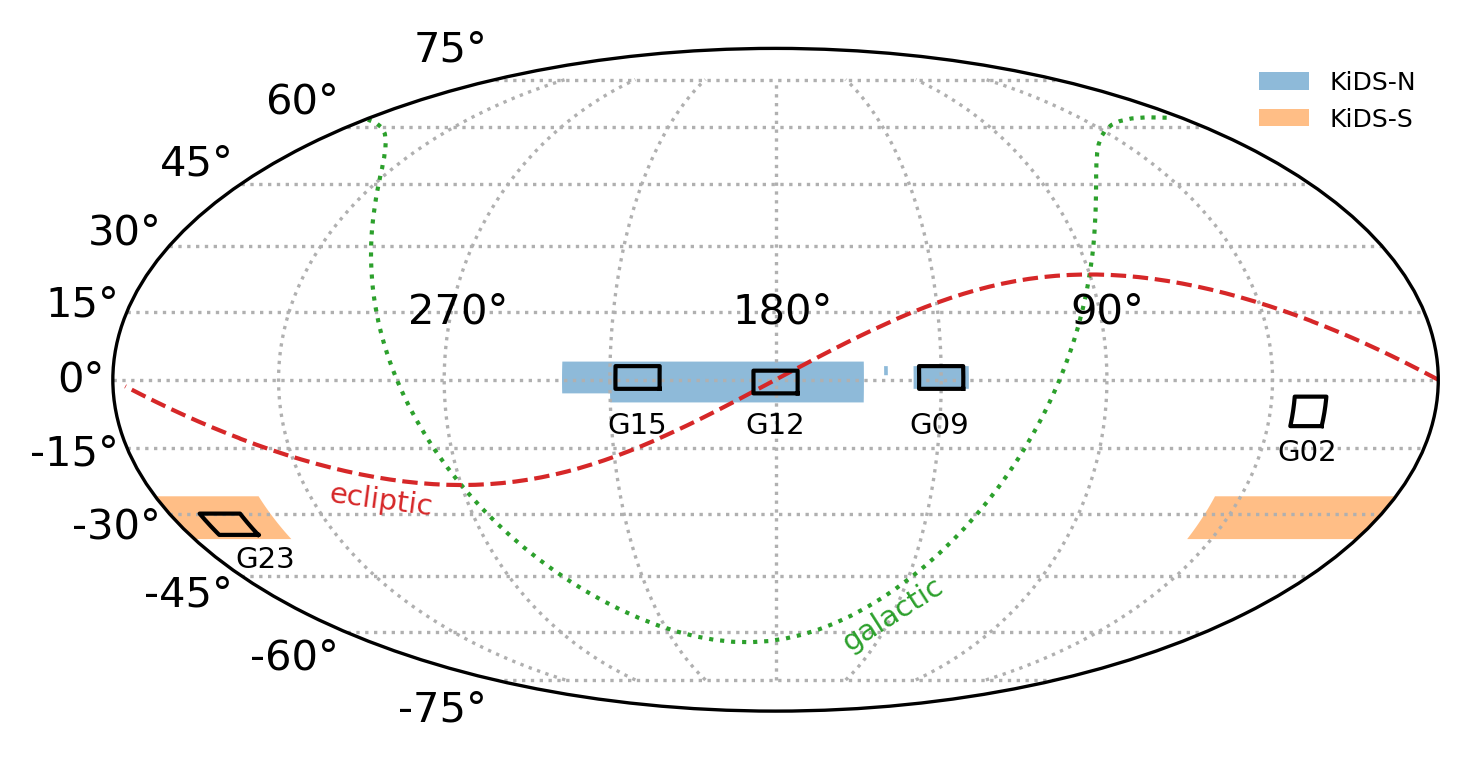

In [262]:
fig = plt.figure(figsize=(5,2.7), dpi=300, facecolor='w')
ax = plt.subplot(111, projection='mollweide')
ax.fill_between(fixRA(raKidsN), fixDEC(decKidsN), label='KiDS-N',
                alpha=0.5, color=plt.cm.tab10(0), ec=None)
ax.fill_between(fixRA(raKidsS), fixDEC(decKidsS), label='KiDS-S',
                alpha=0.5, color=plt.cm.tab10(1), ec=None)
ax.fill_between(fixRA(raKidsNW2), fixDEC(decKidsNW2),
                alpha=0.5, color=plt.cm.tab10(0), ec=None)
ax.fill_between(fixRA(raKidsND2), fixDEC(decKidsND2),
                alpha=0.5, color=plt.cm.tab10(0), ec=None)
ax.plot(fixRA(raGalactic), fixDEC(decGalactic), ls=':', lw=1,
        c=plt.cm.tab10(2))
ax.text(fixRA(135), fixDEC(-55), 'galactic',
        ha='center', va='center',
        rotation=32.5, fontsize=7, c=plt.cm.tab10(2))
ax.plot(fixRA(raEcliptic), fixDEC(decEcliptic), ls='--', lw=1,
        c=plt.cm.tab10(3))
ax.text(fixRA(295), fixDEC(-27), 'ecliptic',
        ha='center', va='center',
        rotation=-7.5, fontsize=7, c=plt.cm.tab10(3))
ax.plot(fixRA(raGama02), fixDEC(decGama02), c='k', lw=1)
ax.text(fixRA(32), fixDEC(-16), 'G02',
        ha='center', va='center', fontsize=7, c='k')
ax.plot(fixRA(raGama09), fixDEC(decGama09), c='k', lw=1)
ax.text(fixRA(135), fixDEC(-10), 'G09',
        ha='center', va='center', fontsize=7, c='k')
ax.plot(fixRA(raGama12), fixDEC(decGama12), c='k', lw=1)
ax.text(fixRA(180), fixDEC(-10), 'G12',
        ha='center', va='center', fontsize=7, c='k')
ax.plot(fixRA(raGama15), fixDEC(decGama15), c='k', lw=1)
ax.text(fixRA(218), fixDEC(-10), 'G15',
        ha='center', va='center', fontsize=7, c='k')
ax.plot(fixRA(raGama23), fixDEC(decGama23), c='k', lw=1)
ax.text(fixRA(345), fixDEC(-41), 'G23',
        ha='center', va='center', fontsize=7, c='k')
xticks = np.arange(45,331,45)
ax.set_xticks(fixRA(xticks))
ax.set_xticklabels(['' for x in xticks])
for x in [90, 180, 270]:
    ax.text(fixRA(x-2), fixDEC(15), f'{x}°',
            ha='center', va='center', fontsize=10)
ax.grid(True, linestyle=':')
plt.legend(frameon=False, ncol=1, loc='upper right', fontsize=6)
plt.tight_layout()
plt.savefig(fname=outdir+'/coverage.pdf', dpi='figure')
plt.show()
plt.close()

In [6]:
# input GKGZ data
cln_file = '../../outputs/gkgz-cleaned.fits.gz'
fin_file = '../../outputs/gkgz-final.fits.gz'
cln = Table.read(cln_file)
fin = Table.read(fin_file)
dat = join(fin, cln, keys='CATAID', join_type='left',
           metadata_conflicts='silent')
#dat.sort('Z_TONRY')

In [7]:
# input GAMA data
mst_file = '../../inputs/sample/gamacats/master-full.fits.gz'
mst = Table.read(mst_file)

In [8]:
# generate sample using initial sample definitions
zlo = mst['Z_TONRY'] >= 0.002
zhi = ((mst['Z_TONRY'] <= 0.15) | (mst['Zfof'] <= 0.15))
zqual = ((mst['NQ'] >= 3) | (mst['NQ2_FLAG'] >= 1))
sclass = mst['SURVEY_CLASS'] >= 1
sample = zlo & zhi & zqual & sclass
smp = mst[sample]
print(f'sample size: {np.sum(sample)} / {len(sample)}')

sample size: 49866 / 221373


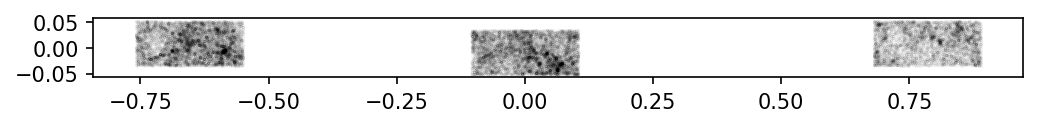

In [9]:
# quick scatter plot (not for publication)
fig, ax = plt.subplots(1, 1, figsize=(8,4), dpi=150, facecolor='w')
ax.scatter(fixRA(smp['RA']), fixDEC(smp['DEC']), c='k', s=0.0001)
ax.set_aspect(1)
plt.show()
plt.close()

In [10]:
# quick view of sample table
smp[:5]

CATAID,OBJID,RA,DEC,FIBERMAG_R,R_PETRO,U_MODEL,G_MODEL,R_MODEL,I_MODEL,Z_MODEL,SURVEY_CODE,Z,NQ,NQ2_FLAG,SPECID,VEL_ERR,NUM_GAMA_SPEC,R_SB,SG_SEP,SG_SEP_JK,K_AUTO,RADIO_FLUX,HATLAS_FLAG,AREA_FLAG,TARGET_FLAGS,SURVEY_OLDCLASS,SURVEY_CLASS,PRIORITY_CLASS,NEIGHBOUR_CLASS,TC_V11_ID,MASK_IC_10,MASK_IC_12,VIS_CLASS,VIS_CLASS_USER,Z_HELIO,Z_LG,Z_CMB,Z_TONRY,Z_TONRY_HIGH,Z_TONRY_LOW,DM_70_30_70,DM_100_30_70,DM_70_25_75,DM_100_25_75,Rpetro,SigErr,GroupID,RankIterCen,SepIterCen,CoSepIterCen,AngSepIterCen,RankBCG,SepBCG,CoSepBCG,AngSepBCG,RankCen,SepCen,CoSepCen,AngSepCen,Nfof,IterCenCATAID,IterCenRA,IterCenDec,IterCenZ,Zfof,Rad50,Rad1Sig,Rad100,RelDen,Zcomp,GroupEdge,VelDisp,VelDispRaw,VelErr,TotRmag,TotFluxProxy,MassProxy,BCGCATAID,BCGRA,BCGDec,Rgap,CenRA,CenDec,RadKurt,AxAng,AxRat,SymKS,VelSkew,VelKurt,Modality,LinkTot,LinkStrenProj,LinkStrenRad,LinkStrenComb,MassA,MassAfunc,LumB,LumBfunc,d3vol,d3area,d2radec,d2raz,d2decz,distortcirc,distortellip,distortsph,URL_IMG
,,deg,deg,mag,mag,mag,mag,mag,mag,mag,,,,,,km / s,,mag / arcsec2,mag,mag,mag,mJy,,,,,,,,,,,,,,,,,,,mag,mag,mag,mag,mag,km / s,,,arcsec,Mpc / h,Mpc / h,,arcsec,Mpc / h,Mpc / h,,arcsec,Mpc / h,Mpc / h,,,deg,deg,,,Mpc / h,Mpc / h,Mpc / h,,,,km / s,km / s,km / s,mag,,,,deg,deg,mag,deg,deg,,deg,,,,,,,,,,Msun/h,Msun/h,Lsun/h,Lsun/h,(Mpc/h)^3,(Mpc/h)^2,(Mpc/h)^2,(Mpc/h)^2,(Mpc/h)^2,,,,
int32,int64,float64,float64,float32,float32,float32,float32,float32,float32,float32,int16,float32,int16,int16,bytes33,float32,int16,float32,float32,float32,float32,float32,int16,int16,int16,int16,int16,int16,int16,int32,float32,float32,int16,bytes11,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int16,float32,float32,float32,int16,float32,float32,float32,int16,float32,float32,float32,int16,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes69
585591,588848899914203338,183.49789499,-0.16766405,18.7268,17.603594,19.758217,18.387272,17.65539,17.203344,16.9255,1,0.12429,5,0,323176188157650944,10.312545,0,20.706959,1.237011,-9.99,-9.99,-9.99,0,2,15613,7,6,2,1,585591,0.0,0.0,0,xxx,0.12429,0.12367078,0.12561366,0.12561366,0.12628905,0.12493826,38.844467,38.069958,38.8547,38.08019,17.603594,10.312545,0,-999,-999.0,-999.0,-999.0,-999,-999.0,-999.0,-999.0,-999,-999.0,-999.0,-999.0,--,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,
585600,588848899914203456,183.42823656,-0.02442331,20.539886,19.335196,20.904034,19.648397,19.229986,18.944212,18.885782,5,0.12242,4,0,G12_Y1_GND1_018,23.41916,1,22.544636,1.7294388,-9.99,-9.99,-9.99,0,2,15512,6,6,2,0,585600,0.0,0.0,0,xxx,0.12242,0.12180355,0.12374143,0.12374143,0.124415636,0.12306723,38.809223,38.034714,38.819305,38.044796,19.335196,23.41916,0,-999,-999.0,-999.0,-999.0,-999,-999.0,-999.0,-999.0,-999,-999.0,-999.0,-999.0,--,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,--,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,
585601,588848899914203457,183.4293652,-0.05253383,20.750858,19.350739,20.477499,19.578978,19.268719,19.187151,19.26956,5,0.02031,3,0,G12_Y1_GN1_024,29.417686,2,22.867329,1.8763599,-9.99,-9.99,-9.99,0,2,15512,6,6,2,1,585601,0.0,0.0,0,xxx,0.02031,0.01974933,0.021511376,0.02202008,0.022553284,0.021494107,34.905533,34.131023,34.907326,34.132816,19.350739,29.417686,202920,2,319.6621,0.10244168,0.100222595,2,319.6621,0.10244168,0.100222595,2,179.21289,0.05743211,0.05618802,3,585584,183.51649501,-0.06964999,0.022141559,0.022141559,0.102441676,0.13077886,0.1811561,0.109571345,0.99

In [87]:
# cosmology functions
def z_to_dist(z):
    cosmo = FlatLambdaCDM(H0=70, Om0=0.3)
    return cosmo.luminosity_distance(z)
def mag_to_Mag(mag, z):
    D = z_to_dist(z)
    Mag = mag - 5*(np.log10(D/(u.pc))-1)
    return Mag

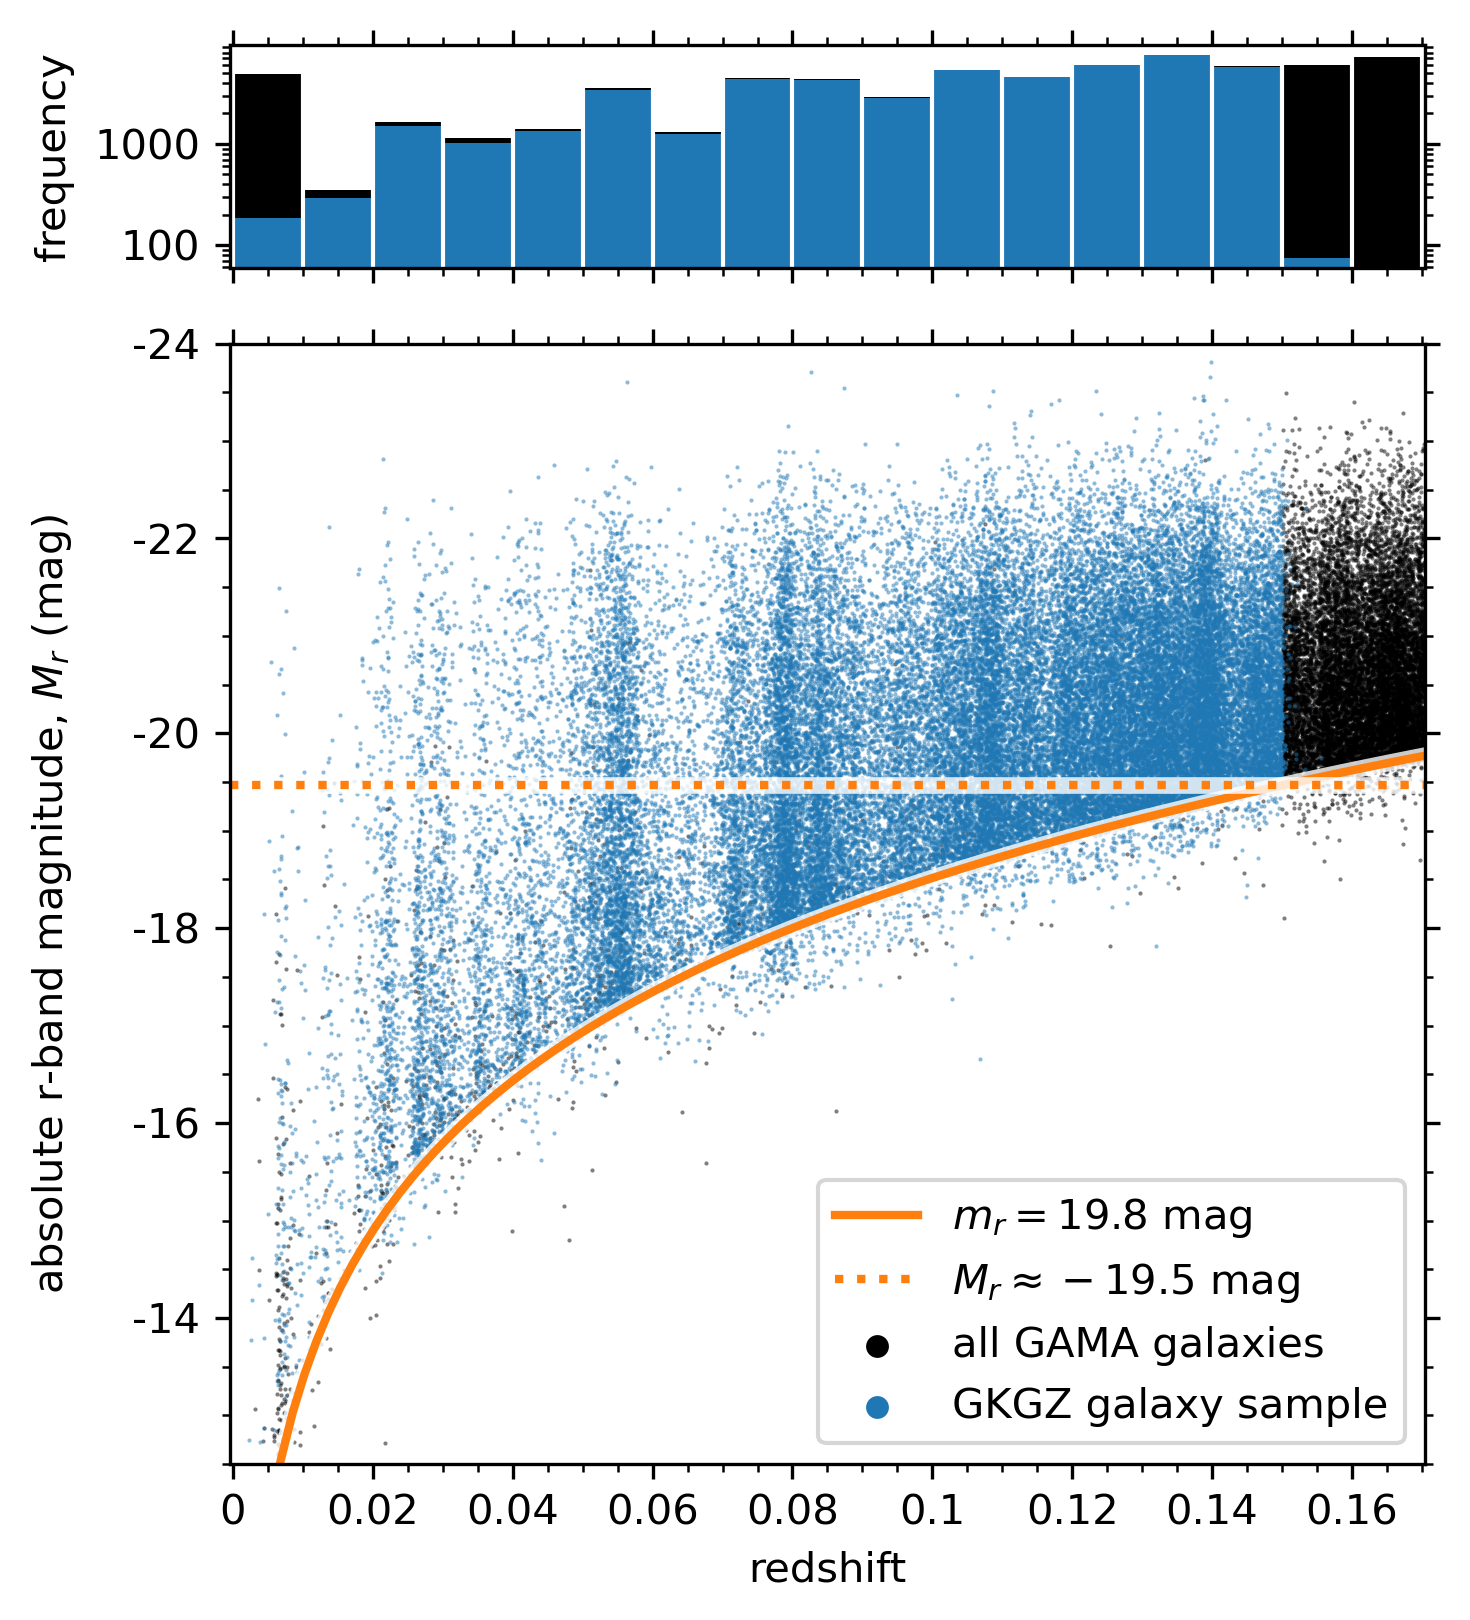

In [273]:
# redshift-magnitude plot
zz = mst['Z_TONRY']
DM = mst['DM_70_30_70']
mr = mst['R_PETRO']
Mr = mr - DM

# plotting limits
outerZLim = [0-5e-4, 0.17+5e-4]
magLim = [-15, -23]
outerMagLim = [magLim[0]+2.5, magLim[1]-1]
volume_redshift_bounds = (0.02, 0.15)
survey_mag_limit = 19.8
MagComplete = mag_to_Mag(survey_mag_limit,
                         np.max(volume_redshift_bounds))
# cosmetic
winsorColor = 'grey'
lw = 2
cols = plt.rcParams['axes.prop_cycle'].by_key()['color']
cols[0], cols[1] = cols[1], cols[0]

# figure
fig = plt.figure(figsize=(5,5.5), dpi=300, facecolor='white')
gs = matplotlib.gridspec.GridSpec(5, 1, figure=fig)
fmt = matplotlib.ticker.FuncFormatter(lambda y, _:'{:g}'.format(y))

# axis
ax = fig.add_subplot(gs[-4:,:])
ax.minorticks_on()
ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', left=True, right=True)
plt_conf = dict(s=1, alpha=0.5, edgecolor=None, linewidth=0)
ax.scatter(zz[~sample], Mr[~sample], **plt_conf, c='k',
           label='all GAMA galaxies')
ax.scatter(zz[sample], Mr[sample], **plt_conf,
           label='GKGZ galaxy sample')
ax.set_xlabel('redshift')
# ax.set_ylabel('$M_r$', rotation=90)
ax.set_ylabel('absolute r-band magnitude, $M_r$ (mag)',
              labelpad=14)
ax.set_xlim(outerZLim)
ax.set_ylim(outerMagLim)
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
zs = np.linspace(1e-5, outerZLim[1], 101)
Mlims = mag_to_Mag(survey_mag_limit, zs)
ax.plot(zs, Mlims, c='w', lw=lw+2, alpha=0.8,
        label='')
ax.plot(zs, Mlims, c=cols[0], lw=lw,
        label=f'$m_r={survey_mag_limit}$ mag')
ax.axhline(MagComplete, c='w', ls='solid', lw=lw+2,
           label='', alpha=0.8)
ax.axhline(MagComplete, c=cols[0], ls='dotted', lw=lw,
           label=f'$M_r\\approx{MagComplete:.01f}$ mag')

# # Winsor limits
# z_range = np.diff(volume_redshift_bounds)[0]
# mag_range = np.diff(magLim)[0]
# rect = matplotlib.patches.Rectangle((volume_redshift_bounds[0],
#                                      magLim[0]),
#                                     z_range,
#                                     mag_range,
#                                     linewidth=2,
#                                     edgecolor=winsorColor,
#                                     facecolor='none',
#                                     linestyle='--', 
#                                     label='Winsorize limits',)
# ax.add_patch(rect)

# legend
leg = ax.legend(loc='lower right')
for lh in leg.legendHandles:
    lh.set_alpha(1)
    if hasattr(lh, '_sizes'):
        lh._sizes = [30]

# marginal histogram
ax = fig.add_subplot(gs[:-4,:])
ax.minorticks_on()
ax.tick_params(axis='x', which='both', bottom=True, top=True)
ax.tick_params(axis='y', which='both', left=True, right=True)
# histZBins = np.linspace(volume_redshift_bounds[0],
#                         volume_redshift_bounds[-1], 14)
# histZBins = np.insert(histZBins, 0, 0)
# histZBins = np.append(histZBins, 0.2)
# if np.max(volume_redshift_bounds) < np.max(zz):
#     histZBins += [np.max(zz)]
histZBins = np.arange(0, 0.2, 0.01)
h1 = ax.hist(zz[zz<0.2], bins=histZBins, log=True, label='',
             edgecolor=None, color='k')
h2 = ax.hist(zz[sample], bins=histZBins, log=True, label='',
             edgecolor=None, color=cols[1])
_ = [ax.axvline(x, c='w', lw=1) for x in histZBins]
# ax.axvline(volume_redshift_bounds[0],
#            c='w',ls='-',lw=lw+3,label='')
# ax.axvline(volume_redshift_bounds[0],
#            c=winsorColor,ls='--',lw=lw,label='')
# ax.axvline(volume_redshift_bounds[-1],
#            c='w',ls='-',lw=lw+3,label='')
# ax.axvline(volume_redshift_bounds[-1],
#            c=winsorColor,ls='--',lw=lw,label='Winsorize limits')
ax.set_xlim(outerZLim)
ax.xaxis.set_major_formatter(fmt)
ax.yaxis.set_major_formatter(fmt)
ax.set_xticklabels([])
ax.set_ylabel('frequency', labelpad=5)

plt.tight_layout()
plt.savefig(fname=outdir+'/redshiftmag.png', dpi='figure')
plt.show()
plt.close()

In [18]:
# Notebook finish up
nbt1, nbt1str = timecheck(nbt0)
print(f'Notebook end time:\n   {nbt1str}')
#--------------------------------68-------------------------------->

Notebook end time:
   2020-12-09 20:47:22 CST (elapsed: 00:04:07)
